In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
import os
from pathlib import Path


In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Set folder paths for outputs

In [3]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'bank')

# Read the file

In [4]:
df= pd.read_csv(DATA / 'bank_additional_full.csv')

In [5]:
def remove_outlier(df: pd.DataFrame, column: str, outlier_assumption: float) -> pd.DataFrame:
    mean = np.mean(df[column])
    std = np.std(df[column])
    
    minimum = mean - outlier_assumption * std
    maximum = mean + outlier_assumption * std
    
    is_outlier = (df[column] < minimum) | (df[column] > maximum)

    df = df[~is_outlier]

    
    return df

In [6]:
df= remove_outlier(df, 'age', 2.5)
df= remove_outlier(df, 'campaign', 2.5)
df= remove_outlier(df, 'emp.var.rate', 2.5)
df= remove_outlier(df, 'cons.price.idx', 2.5)
df= remove_outlier(df, 'cons.conf.idx', 2.5)
df= remove_outlier(df, 'euribor3m', 2.5)
df= remove_outlier(df, 'nr.employed', 2.5)

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [8]:
is_pdays_999 = df['pdays'] == 999
df.loc[is_pdays_999, 'pdays_c'] = "never contacted"
df.loc[~is_pdays_999, 'pdays_c'] = pd.qcut(df.loc[~is_pdays_999, 'pdays'], 4, labels=["very recently contacted","recently contacted", "moderately recently contacted", "contacted long ago"])
df[['pdays_c', 'pdays']]

df.drop('pdays', 1, inplace= True)

In [9]:
is_previous_0 = df['previous'] == 0
df.loc[~is_previous_0, 'previous_c'] = pd.cut(df.previous,bins=[0, 1, 4, 7],labels=["contacted once", "rarely contacted", "frequently contacted"])
df.loc[is_previous_0, 'previous_c'] = "never contacted"
df[['previous_c', 'previous']]

df.drop('previous', 1, inplace= True)

In [10]:
#### In order to feed the data to any machine learning method, 
### it's convenient to change strings to numeric values. So, we are going to change 'no' to 0 and 'yes' to 1
is_purchased = df['y'] == 'yes'
df.loc[is_purchased, 'target'] = 1
df.loc[~is_purchased, 'target'] = 0
df[['target', 'y']]
df.drop('y', 1, inplace= True)

In [12]:
df_num= df[['age','duration','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','target']]
corr_num = df_num.corr()
corr_num

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
age,1.000000,-0.006561,0.006875,0.081826,0.054775,0.109962,0.092023,0.077782,-0.024210
duration,-0.006561,1.000000,-0.037328,-0.014408,0.005740,-0.012044,-0.017155,-0.024651,0.423297
campaign,0.006875,-0.037328,1.000000,0.101920,0.087973,-0.007239,0.081965,0.095540,-0.046072
emp.var.rate,0.081826,-0.014408,0.101920,1.000000,0.845136,0.328424,0.978759,0.954690,-0.257349
cons.price.idx,0.054775,0.005740,0.087973,0.845136,1.000000,0.190927,0.805977,0.735563,-0.185322
cons.conf.idx,0.109962,-0.012044,-0.007239,0.328424,0.190927,1.000000,0.397912,0.217505,0.027898
euribor3m,0.092023,-0.017155,0.081965,0.978759,0.805977,0.397912,1.000000,0.962600,-0.248442
nr.employed,0.077782,-0.024651,0.095540,0.954690,0.735563,0.217505,0.962600,1.000000,-0.274426
target,-0.024210,0.423297,-0.046072,-0.257349,-0.185322,0.027898,-0.248442,-0.274426,1.000000


In [13]:
# emp.var.rate and nr.employed are highly correlated with euribor3m. 
# That's why former two are removed to get rid of multi-collinearity.
# Duration column is substantially correlated to target 
# and could be a good predictor of target outcome. 
# However, one can not know call duration before making the call. 
# That's why this column is removed so that the model can generalise on unseen data

In [14]:
df.drop('duration',1,inplace=True)
df.drop('emp.var.rate',1,inplace=True)
df.drop('nr.employed',1,inplace=True)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df_feature= df.drop('target',1)
df_target= df[['target']]

In [17]:
print(Counter(df['target']))

Counter({0.0: 32599, 1.0: 3519})


In [18]:
# Num of minority instances is 3519 and majority instances is 32599

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder

In [20]:
# Label encode categorical variables

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# Create helper functions

In [21]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [10], 'max_features': [5, 10],
'min_samples_leaf': [3, 5], 'min_samples_split': [2, 4], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

## evaluate function generates the classification report of the loaded model based on the list of x and y values

def evaluate(x, y, threshold):
    x = np.array(x)
    y = np.ravel(y)
    pred = (loaded_model.predict_proba(x)[:,1] >= threshold).astype(bool)
    print(pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted']))
    print(classification_report(y, pred,digits=4))
    return None;

## generate_curves function creates ROC-AUC and PR-AUC curve of the loaded model and compare that wth the random classifier
def generate_curves(filename_old, filename_new, X_test, y_test):   

    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    loaded_model_old = pickle.load(open(filename_old, 'rb'))
    loaded_model_new = pickle.load(open(filename_new, 'rb'))

    test_prob_old = loaded_model_old.predict_proba(X_test)[:, 1]
    test_prob_new = loaded_model_new.predict_proba(X_test)[:, 1]
    
    fpr_old, tpr_old, _ = roc_curve(y_test,  test_prob_old)
    roc_auc_old = roc_auc_score(y_test,  test_prob_old)
    ax1.plot([0, 1], [0, 1], linestyle='--',label ='random, auc = %.3f'% 0.5, c = 'blue')
    ax1.plot(fpr_old, tpr_old ,label ='SMOTE-NC, auc = %.3f'% roc_auc_old, c= 'green')
    
    fpr_new, tpr_new, _ = roc_curve(y_test,  test_prob_new)
    roc_auc_new = roc_auc_score(y_test,  test_prob_new)
    ax1.plot(fpr_new, tpr_new ,label ='SMOTE-ENC, auc = %.3f'% roc_auc_new, c= 'red')
    
    ax1.legend(loc=4)

    ax1.set_title('ROC curve' ,fontsize=16)
    ax1.set_ylabel('True Positive Rate',fontsize=14)
    ax1.set_xlabel('False Positive Rate',fontsize=14)

    ax2 = f.add_subplot(122)
    

    precision_old, recall_old, _ = precision_recall_curve(y_test, test_prob_old)
    precision_new, recall_new, _ = precision_recall_curve(y_test, test_prob_new)
    
    auc_score_old = auc(recall_old, precision_old)
    auc_score_new = auc(recall_new, precision_new)
    
    random_auc = y_test.sum()/len(y_test)
    
    ax2.plot([0, 1], [random_auc, random_auc], linestyle='--', label ='random, auc = %.3f'% random_auc, c ='blue')
    ax2.plot(recall_old, precision_old, label = 'SMOTE-NC, auc=%.3f'% auc_score_old, c = 'green')
    ax2.plot(recall_new, precision_new, label = 'SMOTE-ENC, auc=%.3f'% auc_score_new, c = 'red')
    
    ax2.set_title('Precision Recall curve' ,fontsize=16)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_xlabel('Recall',fontsize=14)
    ax2.legend(loc='best')
    plt.show()
    f.savefig(REPORTS / 'bank_roc_prc.jpeg', bbox_inches='tight')
    
    return None;

In [22]:
encoded_df = MultiColumnLabelEncoder(columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                                               'poutcome', 'pdays_c', 'previous_c']).fit_transform(df_feature)

In [23]:
encoded_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'poutcome',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'pdays_c',
       'previous_c'],
      dtype='object')

In [24]:
# Split the raw data into train and test set. Split ratio = 75:25
X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [25]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [26]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [28]:
# Our New Proposed SMOTE Method
from scipy import stats
class MySMOTENC():
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        
    def chk_neighbors(self, nn_object, additional_neighbor):
        if isinstance(nn_object, Integral):
            return NearestNeighbors(n_neighbors=nn_object + additional_neighbor)
        elif isinstance(nn_object, KNeighborsMixin):
            return clone(nn_object)
        else:
            raise_isinstance_error(nn_name, [int, KNeighborsMixin], nn_object)     
    
    def generate_samples(self, X, nn_data, nn_num, rows, cols, steps, continuous_features_,):
        rng = check_random_state(42)

        diffs = nn_data[nn_num[rows, cols]] - X[rows]

        if sparse.issparse(X):
            sparse_func = type(X).__name__
            steps = getattr(sparse, sparse_func)(steps)
            X_new = X[rows] + steps.multiply(diffs)
        else:
            X_new = X[rows] + steps * diffs 

        X_new = (X_new.tolil() if sparse.issparse(X_new) else X_new)
        # convert to dense array since scipy.sparse doesn't handle 3D
        nn_data = (nn_data.toarray() if sparse.issparse(nn_data) else nn_data)

        all_neighbors = nn_data[nn_num[rows]]

        for idx in range(continuous_features_.size, X.shape[1]):

            mode = stats.mode(all_neighbors[:, :, idx], axis = 1)[0]

            X_new[:, idx] = np.ravel(mode)            
        return X_new
    
    def make_samples(self, X, y_dtype, y_type, nn_data, nn_num, n_samples, continuous_features_, step_size=1.0):
        random_state = check_random_state(42)
        samples_indices = random_state.randint(low=0, high=len(nn_num.flatten()), size=n_samples)    
        steps = step_size * random_state.uniform(size=n_samples)[:, np.newaxis]
        rows = np.floor_divide(samples_indices, nn_num.shape[1])
        cols = np.mod(samples_indices, nn_num.shape[1])

        X_new = self.generate_samples(X, nn_data, nn_num, rows, cols, steps, continuous_features_)
        y_new = np.full(n_samples, fill_value=y_type, dtype=y_dtype)
        
        return X_new, y_new
    
    def cat_corr_pandas(self, X, target_df, target_column, target_value):
    # X has categorical columns
        categorical_columns = list(X.columns)
        X = pd.concat([X, target_df], axis=1)

        # filter X for target value
        is_target = X.loc[:, target_column] == target_value
        X_filtered = X.loc[is_target, :]

        X_filtered.drop(target_column, axis=1, inplace=True)

        # get columns in X
        nrows = len(X)
        encoded_dict_list = []
        nan_dict = dict({})
        c = 0
        imb_ratio = len(X_filtered)/len(X)
        OE_dict = {}
        
        for column in categorical_columns:
            for level in list(X.loc[:, column].unique()):
                
                # filter rows where level is present
                row_level_filter = X.loc[:, column] == level
                rows_in_level = len(X.loc[row_level_filter, :])
                
                # number of rows in level where target is 1
                O = len(X.loc[is_target & row_level_filter, :])
                E = rows_in_level * imb_ratio
                # Encoded value = chi, i.e. (observed - expected)/expected
                ENC = (O - E) / E
                OE_dict[level] = ENC
                
            encoded_dict_list.append(OE_dict)

            X.loc[:, column] = X[column].map(OE_dict)
            nan_idx_array = np.ravel(np.argwhere(np.isnan(X.loc[:, column])))
            if len(nan_idx_array) > 0 :
                nan_dict[c] = nan_idx_array
            c = c + 1
            X.loc[:, column].fillna(-1, inplace = True)
            
        X.drop(target_column, axis=1, inplace=True)
        return X, encoded_dict_list, nan_dict

    def fit_resample(self, X, y):
        X_cat_encoded, encoded_dict_list, nan_dict = self.cat_corr_pandas(X.iloc[:,np.asarray(self.categorical_features)], y, target_column='target', target_value=1)
#         X_cat_encoded = np.ravel(np.array(X_cat_encoded))
        X_cat_encoded = np.array(X_cat_encoded)
        y = np.ravel(y)
        X = np.array(X)

        unique, counts = np.unique(y, return_counts=True)
        target_stats = dict(zip(unique, counts))
        n_sample_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy = {key: n_sample_majority - value for (key, value) in target_stats.items() if key != class_majority}

        n_features_ = X.shape[1]
        categorical_features = np.asarray(self.categorical_features)
        if categorical_features.dtype.name == 'bool':
            categorical_features_ = np.flatnonzero(categorical_features)
        else:
            if any([cat not in np.arange(n_features_) for cat in categorical_features]):
                raise ValueError('Some of the categorical indices are out of range. Indices'
                            ' should be between 0 and {}'.format(n_features_))
            categorical_features_ = categorical_features

        continuous_features_ = np.setdiff1d(np.arange(n_features_),categorical_features_)

        target_stats = Counter(y)
        class_minority = min(target_stats, key=target_stats.get)

        X_continuous = X[:, continuous_features_]
        X_continuous = check_array(X_continuous, accept_sparse=['csr', 'csc'])
        X_minority = safe_indexing(X_continuous, np.flatnonzero(y == class_minority))

        if sparse.issparse(X):
            if X.format == 'csr':
                _, var = sparsefuncs_fast.csr_mean_variance_axis0(X_minority)
            else:
                _, var = sparsefuncs_fast.csc_mean_variance_axis0(X_minority)
        else:
            var = X_minority.var(axis=0)
        median_std_ = np.median(np.sqrt(var))

        X_categorical = X[:, categorical_features_]
        X_copy = np.hstack((X_continuous, X_categorical))

        X_cat_encoded = X_cat_encoded * median_std_

        X_encoded = np.hstack((X_continuous, X_cat_encoded))
        X_resampled = X_encoded.copy()
        y_resampled = y.copy()


        for class_sample, n_samples in sampling_strategy.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = safe_indexing(X_encoded, target_class_indices)
            nn_k_ = self.chk_neighbors(5, 1)
            nn_k_.fit(X_class)

            nns = nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
            X_new, y_new = self.make_samples(X_class, y.dtype, class_sample, X_class, nns, n_samples, continuous_features_, 1.0)

            if sparse.issparse(X_new):
                X_resampled = sparse.vstack([X_resampled, X_new])
                sparse_func = 'tocsc' if X.format == 'csc' else 'tocsr'
                X_resampled = getattr(X_resampled, sparse_func)()
            else:
                X_resampled = np.vstack((X_resampled, X_new))
            y_resampled = np.hstack((y_resampled, y_new))
            
        X_resampled_copy = X_resampled.copy()
        i = 0
        for col in range(continuous_features_.size, X.shape[1]):
            encoded_dict = encoded_dict_list[i]
            i = i + 1
            for key, value in encoded_dict.items():
                X_resampled_copy[:, col] = np.where(np.round(X_resampled_copy[:, col], 4) == np.round(value * median_std_, 4), key, X_resampled_copy[:, col])

        for key, value in nan_dict.items():
            for item in value:
                X_resampled_copy[item, continuous_features_.size + key] = X_copy[item, continuous_features_.size + key]

               
        X_resampled = X_resampled_copy   
        indices_reordered = np.argsort(np.hstack((continuous_features_, categorical_features_)))
        if sparse.issparse(X_resampled):
            col_indices = X_resampled.indices.copy()
            for idx, col_idx in enumerate(indices_reordered):
                mask = X_resampled.indices == col_idx
                col_indices[mask] = idx
            X_resampled.indices = col_indices
        else:
            X_resampled = X_resampled[:, indices_reordered]
        return X_resampled, y_resampled

In [29]:
## Apply the random-forest classifier along with the NEW SMOTE method
filename = (MODELS / 'bank_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,11,15,16]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  3.3min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


In [30]:
## Apply the random-forest classifier along with the existng SMOTE-NC method
filename = (MODELS / 'bank_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [1,2,3,4,5,6,7,8,9,11,15,16]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  7.4min remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.4min finished


In [31]:
## Evaluate SMOTE-NC performance on train and test set

filename = (MODELS / 'bank_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

evaluate(X_train, y_train, threshold)
evaluate(X_test, y_test, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted  False  True 
Actual                 
0.0        21035   3405
1.0         1116   1532
              precision    recall  f1-score   support

         0.0     0.9496    0.8607    0.9030     24440
         1.0     0.3103    0.5785    0.4040      2648

   micro avg     0.8331    0.8331    0.8331     27088
   macro avg     0.6300    0.7196    0.6535     27088
weighted avg     0.8871    0.8331    0.8542     27088

Predicted  False  True 
Actual                 
0.0         6992   1167
1.0          432    439
              precision    recall  f1-score   support

         0.0     0.9418    0.8570    0.8974      8159
         1.0     0.2733    0.5040    0.3545       871

   micro avg     0.8229    0.8229    0.8229      9030
   macro avg     0.6076    0.6805    0.6259      9030
weighted avg     0.8773    0.8229    0.8450      9030



array([0.03525379, 0.0632826 , 0.01451888, 0.02154058, 0.05641967,
       0.00564938, 0.04854215, 0.07272161, 0.04108414, 0.02677172,
       0.06009373, 0.03115586, 0.10289726, 0.09870765, 0.31043813,
       0.00392131, 0.00700156])

In [32]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')
evaluate(X_train, y_train, threshold)
evaluate(X_test, y_test, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted  False  True 
Actual                 
0.0        21846   2594
1.0         1208   1440
              precision    recall  f1-score   support

         0.0     0.9476    0.8939    0.9199     24440
         1.0     0.3570    0.5438    0.4310      2648

   micro avg     0.8596    0.8596    0.8596     27088
   macro avg     0.6523    0.7188    0.6755     27088
weighted avg     0.8899    0.8596    0.8722     27088

Predicted  False  True 
Actual                 
0.0         7290    869
1.0          463    408
              precision    recall  f1-score   support

         0.0     0.9403    0.8935    0.9163      8159
         1.0     0.3195    0.4684    0.3799       871

   micro avg     0.8525    0.8525    0.8525      9030
   macro avg     0.6299    0.6810    0.6481      9030
weighted avg     0.8804    0.8525    0.8646      9030



array([0.03952855, 0.03184745, 0.01906433, 0.0253297 , 0.03665847,
       0.00554627, 0.05507645, 0.04916418, 0.04332758, 0.04126102,
       0.02876982, 0.0353268 , 0.11166295, 0.10367363, 0.35842774,
       0.00797493, 0.00736013])

In [33]:
# Compare variable importance between SMOTE-NC and SMOTE-ENC
filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model1 = pickle.load(open(filename, 'rb'))
filename = (MODELS / 'bank_smotenc.sav')
loaded_model2 = pickle.load(open(filename, 'rb'))
feature_df = pd.DataFrame(np.vstack((loaded_model1.steps[1][1].feature_importances_,loaded_model2.steps[1][1].feature_importances_,
                         (loaded_model1.steps[1][1].feature_importances_ - loaded_model2.steps[1][1].feature_importances_))))
feature_df.index = ('new', 'old', 'imp_increase')
feature_df.columns = X_train.columns
feature_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,cons.price.idx,cons.conf.idx,euribor3m,pdays_c,previous_c
new,0.039529,0.031847,0.019064,0.025330,0.036658,0.005546,0.055076,0.049164,0.043328,0.041261,0.028770,0.035327,0.111663,0.103674,0.358428,0.007975,0.007360
old,0.035254,0.063283,0.014519,0.021541,0.056420,0.005649,0.048542,0.072722,0.041084,0.026772,0.060094,0.031156,0.102897,0.098708,0.310438,0.003921,0.007002
imp_increase,0.004275,-0.031435,0.004545,0.003789,-0.019761,-0.000103,0.006534,-0.023557,0.002243,0.014489,-0.031324,0.004171,0.008766,0.004966,0.047990,0.004054,0.000359


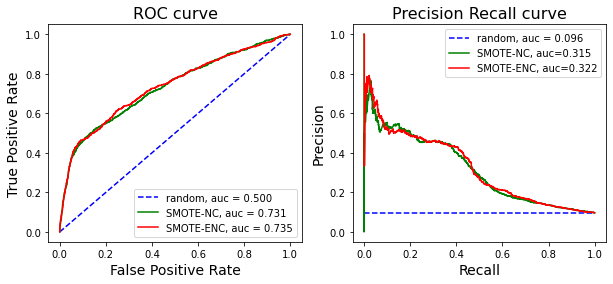

In [34]:
##Create ROC-AUC and PR-AUC curve
generate_curves(MODELS / 'bank_smotenc.sav', MODELS / 'bank_mysmotenc.sav', X_test, y_test)

<Figure size 720x720 with 0 Axes>

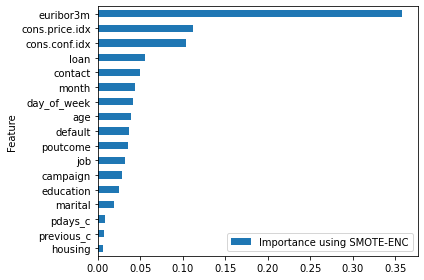

In [35]:
## Plot feature importance using our new SMOTE-ENC method

filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Importance using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'bank_newsmote.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

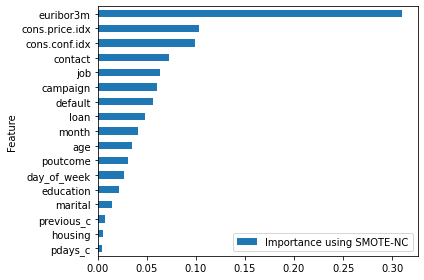

In [36]:
## Plot feature importance using the existing SMOTE-NC method

filename = (MODELS / 'bank_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Importance using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'bank_oldsmote.jpeg', bbox_inches='tight')